# Calibrating ensemble models with Bayes (equal size binning)

### Bayes theorem for calibrating binary classification models

Assuming that we know the predictions of an ensemble model trained to predict a binary variable *True_Label=\{0,1}* and the prior probability *P(1)* which is the probability for the event *True_Label=1*, we can use the *Bayesian* theorem to compute the calibrated prediction or posterior probability of the model.

\begin{equation} P(1|Prediction) = \frac{P(Prediction|1)*P(1)}{P(Prediction|1)*P(1)+P(Prediction|0)*P(0)} \end{equation}

### Import libraries

Import libraries and activate multiple outputs by notebook cell.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Import the ensemble model predictions

Import the *predictions* of the ensemble model and the *true label* (binary in this example) for each observation in a *validation* dataset, not used for training the model.

In [2]:
data = pd.read_excel('Ensemble model predictions in validation dataset.xlsx')
prediction = data["Prediction"]
true_label = data["True_Label"]
data.head()
data.shape

,True_Label,Prediction
0,0,0.064223
1,0,0.413014
2,1,0.180336
3,0,0.223579
4,0,0.131419


(8792, 2)

The predictions are not calibrated since the prediction range of the ensemble model is not [0,1] equivalent to theoretical the range of probability for the event *True_Label=1*.

In [3]:
min(prediction), max(prediction)

(0.0194706935435534, 0.758970975875854)

### Prior probabilities

Compute the prior probability for the event *True_Label=1* equivalent to *P(1)* and *P(0)* in the initial formula. You can see that the *validation* dataset is unbalanced, which means that the % of *True_Labels=1* is different from 50%.

In [4]:
p1 = np.mean(true_label)
p0 = 1-p1
p1, p0

(0.2373748862602366, 0.7626251137397634)

### Conditional distributions by binning predictions

For binning the prediction in groups, compute the *decils* of the predictions vector (sorted prediction values that create 10 groups with 10% of predictions in each one). You can see that the percentile 0% and 100% correspond to the minimum and maximum predicted values.

In [5]:
bins = np.percentile(prediction,np.arange(0,101,10))
bins

array([0.01947069, 0.08151739, 0.11682924, 0.15258642, 0.19085579,
       0.23184413, 0.28074329, 0.33209348, 0.39333202, 0.47083429,
       0.75897098])

Compute the frequeny distribution of predictions with *True_Label=1* by bins equivalent to *P(Prediction|1)* in the initial formula.

In [6]:
binned_prediction_given1 = np.histogram(prediction[true_label==1],bins)[0]/sum(true_label==1)
binned_prediction_given1

array([0.01341639, 0.03402012, 0.04072832, 0.05366555, 0.08001917,
       0.10158122, 0.11931001, 0.15716339, 0.17968376, 0.22041207])

Compute the frequency distribution of predictions with *True_Label=0* by bins equivalent to *P(Prediction|0)* in the initial formula.

In [7]:
binned_prediction_given0 = np.histogram(prediction[true_label==0],bins)[0]/sum(true_label==0)
binned_prediction_given0

array([0.12706935, 0.12050708, 0.11841909, 0.11439224, 0.10618941,
       0.099478  , 0.09395973, 0.08217748, 0.07516779, 0.06263982])

Check that both conditiona distributions sum 1.

In [8]:
sum(binned_prediction_given1), sum(binned_prediction_given0)

(1.0, 1.0)

### Calibrated predictions

Compute the calibrated prediction or posterior probability by bins.

In [9]:
calibrated_binned_prediction = (p1*binned_prediction_given1)/(p1*binned_prediction_given1+p0*binned_prediction_given0)
calibrated_binned_prediction

array([0.03181818, 0.08077361, 0.0967008 , 0.12741752, 0.18998862,
       0.24118316, 0.28327645, 0.37315131, 0.42662116, 0.52272727])

In [16]:
true_label.groupby(pd.cut(prediction,bins)).apply(np.mean)

Prediction
(0.0195, 0.0815]    0.031854
(0.0815, 0.117]     0.080774
(0.117, 0.153]      0.096701
(0.153, 0.191]      0.127418
(0.191, 0.232]      0.189989
(0.232, 0.281]      0.241183
(0.281, 0.332]      0.283276
(0.332, 0.393]      0.373151
(0.393, 0.471]      0.426621
(0.471, 0.759]      0.522727
Name: True_Label, dtype: float64

### Size of every bin

In [10]:
prediction.groupby(pd.cut(prediction,bins)).size()

Prediction
(0.0195, 0.0815]    879
(0.0815, 0.117]     879
(0.117, 0.153]      879
(0.153, 0.191]      879
(0.191, 0.232]      879
(0.232, 0.281]      879
(0.281, 0.332]      879
(0.332, 0.393]      879
(0.393, 0.471]      879
(0.471, 0.759]      880
Name: Prediction, dtype: int64

### Let's plot the distributions

In [11]:
InteractiveShell.ast_node_interactivity = "none"

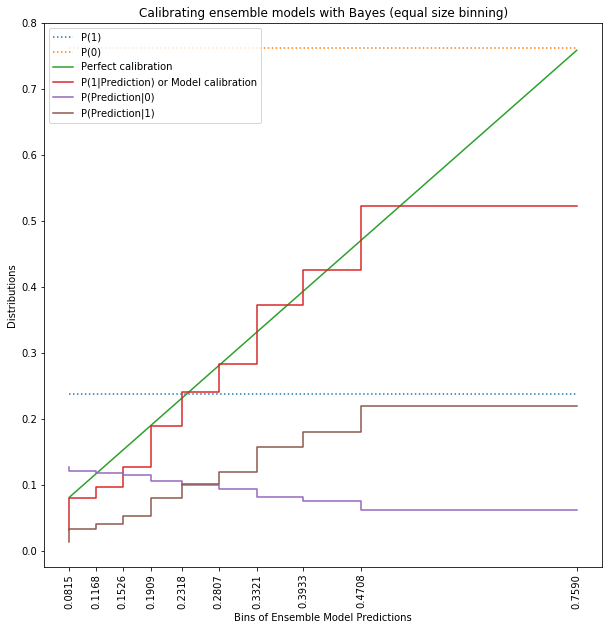

In [12]:
plt.figure(figsize=(10,10))
plt.step(bins[1:],np.repeat(p1,bins.shape[0]-1),label='P(1)',linestyle=":")
plt.step(bins[1:],np.repeat(p0,bins.shape[0]-1),label='P(0)',linestyle=":")
plt.plot([min(bins[1:]),max(bins[1:])],[min(bins[1:]),max(bins[1:])],label="Perfect calibration")
plt.step(bins[1:],calibrated_binned_prediction,label='P(1|Prediction) or Model calibration')
plt.step(bins[1:],binned_prediction_given0,label='P(Prediction|0)')
plt.step(bins[1:],binned_prediction_given1,label='P(Prediction|1)')
plt.xticks(bins[1:],rotation='vertical')
plt.xlabel("Bins of Ensemble Model Predictions")
plt.ylabel("Distributions")
plt.title('Calibrating ensemble models with Bayes (equal size binning)')
plt.legend(loc='upper left')